In [1]:
!pip list

Package                            Version             Editable project location
---------------------------------- ------------------- -------------------------
absl-py                            1.4.0
accelerate                         1.3.0
aiofiles                           22.1.0
aiohappyeyeballs                   2.6.1
aiohttp                            3.11.16
aiosignal                          1.3.2
aiosqlite                          0.21.0
alabaster                          1.0.0
albucore                           0.0.23
albumentations                     2.0.4
ale-py                             0.10.1
alembic                            1.15.2
altair                             5.5.0
annotated-types                    0.7.0
annoy                              1.17.3
ansicolors                         1.1.8
antlr4-python3-runtime             4.9.3
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
args    

In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow


In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

2025-04-18 05:33:28.943352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744954409.137167      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744954409.196547      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass


1. Build Data Loading Functions

In [5]:
import gdown

In [6]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=af98bb93-1e76-4987-9519-6060f7264f15
To: /kaggle/working/data.zip
100%|██████████| 423M/423M [00:04<00:00, 91.0MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [7]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


I0000 00:00:1744954459.815805      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [10]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [11]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [12]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [13]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [14]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    # file_name = os.path.splitext(os.path.basename(path))[0]
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows - Replaced with os.path.basename to handle path irrespective of os
    #file_name = path.split('\\')[-1].split('.')[0]
    #file_name = os.path.basename(path).split('.')[0] # Changed to handle linux paths
    # The previous line was incorrectly extracting the file name when the path contained backslashes
    file_name = os.path.basename(path).replace('\\', '/').split('/')[-1].split('.')[0] # Fixed to handle windows path with backslashes
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [15]:
test_path = '.\\data\\s1\\bbal6n.mpg'



In [16]:

tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [17]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

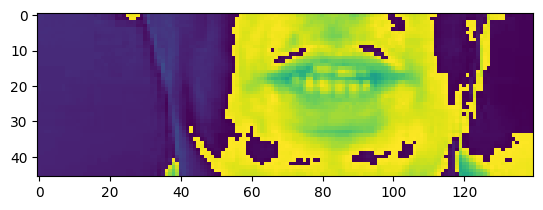

In [18]:
plt.imshow(frames[40])

In [1]:
accuracy="95.79%"

In [19]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [20]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [21]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result


2. Create Data Pipeline

In [22]:
from matplotlib import pyplot as plt

In [23]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [24]:

len(test)

50

In [25]:
frames, alignments = data.as_numpy_iterator().next()

In [26]:
len(frames)

2

In [27]:
sample = data.as_numpy_iterator()

In [28]:
val = sample.next(); val[0]

array([[[[[ 1.4066961 ],
          [ 1.4066961 ],
          [ 1.0159471 ],
          ...,
          [ 0.31259912],
          [ 0.27352422],
          [ 0.27352422]],

         [[ 1.1722467 ],
          [ 1.4066961 ],
          [ 1.055022  ],
          ...,
          [ 0.31259912],
          [ 0.27352422],
          [ 0.27352422]],

         [[ 1.5629956 ],
          [ 1.5629956 ],
          [ 1.4066961 ],
          ...,
          [ 0.31259912],
          [ 0.27352422],
          [ 0.27352422]],

         ...,

         [[ 1.1722467 ],
          [ 1.1331718 ],
          [ 1.1331718 ],
          ...,
          [ 0.03907489],
          [ 0.03907489],
          [ 0.        ]],

         [[ 1.1331718 ],
          [ 1.1331718 ],
          [ 1.1331718 ],
          ...,
          [ 0.03907489],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.1331718 ],
          [ 1.1331718 ],
          [ 1.1331718 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          

In [29]:
import imageio
import numpy as np

# ... (your existing code) ...

val = sample.next()
frames = val[0][0]

# Convert the image data to uint8 before saving
# Scale float32 data to the range 0-255 and convert to uint8
# Squeeze the extra dimension if present
frames_uint8 = np.array([(frame * 255).astype(np.uint8) for frame in frames])
frames_uint8 = frames_uint8.squeeze()  # Remove single-dimensional entries from the shape of an array.

# If frames_uint8 still has shape (x, y, 1), convert to (x, y)
if frames_uint8.ndim == 3 and frames_uint8.shape[-1] == 1:
    frames_uint8 = frames_uint8.squeeze(-1)

imageio.mimsave('./animation.gif', frames_uint8, fps=10)

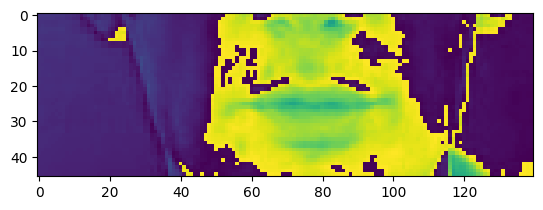

In [30]:
plt.imshow(val[0][0][35])

In [31]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin white sp with n six now'>

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [33]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [34]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

# Build the model to make output shapes accessible
model.build() # This line is added to build the model before accessing output shape.

# Calculate the output shape of the Conv3D layer
conv3d_output_shape = model.layers[-1].output.shape  # Accessing output shape via the layer's output tensor

# Replace TimeDistributed(Flatten()) with Reshape, specifying the target shape
model.add(Reshape((conv3d_output_shape[1], conv3d_output_shape[2] * conv3d_output_shape[3] * conv3d_output_shape[4])))  # Reshape to (timesteps, features)

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 75, 46, 140, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 75, 46, 140, 128)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 75, 23, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 75, 23, 70, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 75, 23, 70, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 75, 11, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 75, 11, 35, 75)      │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 75, 11, 35, 75)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 75, 5, 17, 75)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 75, 6375)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 75, 256)             │       6,660,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
yhat = model.predict(val[0])

I0000 00:00:1744954532.036682      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [37]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b"211111''''''''''''''''qqqqqqqqqqqq777777'''''''''''''''''''''''''''''''''''">

In [38]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b"211111''''''''''''''''qqqqqqqqqqqq777777'''''''''''''''''''''''''''''''''''">

In [39]:
model.input_shape

(None, 75, 46, 140, 1)

In [40]:
model.output_shape

(None, 75, 41)

4. Setup Training Options and Train

In [49]:
def scheduler(epoch, lr):
    if epoch < 30:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))


In [50]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [51]:

class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [52]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [53]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint # Import ModelCheckpoint

# ... your other imports ...

# Create the 'models' directory if it doesn't exist before defining the callback
os.makedirs('models', exist_ok=True)

checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [54]:
schedule_callback = LearningRateScheduler(scheduler)

In [55]:
example_callback = ProduceExample(test)

In [56]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
 78/450 ━━━━━━━━━━━━━━━━━━━━ 4:10 673ms/step - loss: 14.4621

[mpeg1video @ 0x7ecc38013fc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecc38013fc0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - loss: 14.1126

[mpeg1video @ 0x7ecb600cb480] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb600cb480] Warning MVs not available
[mpeg1video @ 0x7ecbac18efc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecbac18efc0] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Original: bin blue at f three soon
Prediction: bin blue at thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white at j nine again
Prediction: place white at nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 700s 2s/step - loss: 14.1119 - val_loss: 9.9061 - learning_rate: 1.0000e-04
Epoch 2/100
 94/450 ━━━━━━━━━━━━━━━━━━━━ 4:04 687ms/step - loss: 12.7055

[mpeg1video @ 0x7ecb50800f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb50800f80] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - loss: 12.7573

[mpeg1video @ 0x7eca8b74d780] ac-tex damaged at 22 17
[mpeg1video @ 0x7eca8b74d780] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Original: set green in o six now
Prediction: set gren in ix now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red at e five again
Prediction: lay red at five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - loss: 12.7576 - val_loss: 9.5004 - learning_rate: 1.0000e-04
Epoch 3/100
360/450 ━━━━━━━━━━━━━━━━━━━━ 1:01 679ms/step - loss: 12.5065

[mpeg1video @ 0x7eccd00fa280] ac-tex damaged at 22 17
[mpeg1video @ 0x7eccd00fa280] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - loss: 12.4290

[mpeg1video @ 0x7ecce40ad080] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecce40ad080] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Original: place green at y three again
Prediction: place gren at tre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white at q three again
Prediction: place white at thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 510s 1s/step - loss: 12.4282 - val_loss: 8.4295 - learning_rate: 1.0000e-04
Epoch 4/100
 15/450 ━━━━━━━━━━━━━━━━━━━━ 4:53 676ms/step - loss: 10.1180

[mpeg1video @ 0x7ecb80049e00] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb80049e00] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - loss: 11.4491

[mpeg1video @ 0x7ecbb403c200] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecbb403c200] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Original: bin blue by z eight now
Prediction: bin blue by eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red by j four now
Prediction: place red by for now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 510s 1s/step - loss: 11.4488 - val_loss: 7.7538 - learning_rate: 1.0000e-04
Epoch 5/100
234/450 ━━━━━━━━━━━━━━━━━━━━ 2:26 680ms/step - loss: 10.7127

[mpeg1video @ 0x7ecb4c045780] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb4c045780] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - loss: 10.7307

[mpeg1video @ 0x7eca8b78bb40] ac-tex damaged at 22 17
[mpeg1video @ 0x7eca8b78bb40] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Original: lay red at r zero now
Prediction: lay red at zro now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green with x two now
Prediction: set gren with two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - loss: 10.7307 - val_loss: 6.9880 - learning_rate: 1.0000e-04
Epoch 6/100
  6/450 ━━━━━━━━━━━━━━━━━━━━ 5:01 679ms/step - loss: 9.3569

[mpeg1video @ 0x7eccdc0d1780] ac-tex damaged at 22 17
[mpeg1video @ 0x7eccdc0d1780] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - loss: 10.3770

[mpeg1video @ 0x7ecb48173600] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb48173600] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Original: set red in n four now
Prediction: set red in four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue at t six now
Prediction: set blue at six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 510s 1s/step - loss: 10.3766 - val_loss: 6.5754 - learning_rate: 1.0000e-04
Epoch 7/100
426/450 ━━━━━━━━━━━━━━━━━━━━ 16s 676ms/step - loss: 9.4503

[mpeg1video @ 0x7ecba41048c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecba41048c0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - loss: 9.4499

[mpeg1video @ 0x7eccb81ab7c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7eccb81ab7c0] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Original: lay white at l three soon
Prediction: lay white at thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white in u five soon
Prediction: set white in five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 511s 1s/step - loss: 9.4499 - val_loss: 6.7247 - learning_rate: 1.0000e-04
Epoch 8/100
436/450 ━━━━━━━━━━━━━━━━━━━━ 9s 676ms/step - loss: 9.2445 

[mpeg1video @ 0x7ecb600852c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb600852c0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - loss: 9.2363

[mpeg1video @ 0x7ecb7f24e540] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb7f24e540] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Original: set green by p five soon
Prediction: set gren by five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white at u eight now
Prediction: set white at eiht now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - loss: 9.2357 - val_loss: 5.7697 - learning_rate: 1.0000e-04
Epoch 9/100
410/450 ━━━━━━━━━━━━━━━━━━━━ 26s 675ms/step - loss: 8.4717

[mpeg1video @ 0x7ecce402f100] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecce402f100] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - loss: 8.4648

[mpeg1video @ 0x7ecb44049580] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb44049580] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Original: place blue with j four please
Prediction: place blue with four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green by g zero please
Prediction: lay gren by zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 508s 1s/step - loss: 8.4646 - val_loss: 5.7790 - learning_rate: 1.0000e-04
Epoch 10/100
338/450 ━━━━━━━━━━━━━━━━━━━━ 1:15 671ms/step - loss: 7.8637

[mpeg1video @ 0x7ecbb0460bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecbb0460bc0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - loss: 7.8868

[mpeg1video @ 0x7ecce0049640] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecce0049640] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Original: set white in o zero now
Prediction: set white in zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red sp with l five soon
Prediction: lay red with l five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 507s 1s/step - loss: 7.8871 - val_loss: 4.7178 - learning_rate: 1.0000e-04
Epoch 11/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - loss: 7.3642

[mpeg1video @ 0x7ecba0002340] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecba0002340] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Original: lay blue at q seven again
Prediction: lay blue at seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white by c zero now
Prediction: set white by zoro now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 508s 1s/step - loss: 7.3641 - val_loss: 4.6970 - learning_rate: 1.0000e-04
Epoch 12/100
 25/450 ━━━━━━━━━━━━━━━━━━━━ 4:46 675ms/step - loss: 6.7305

[mpeg1video @ 0x7ecce802c6c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecce802c6c0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - loss: 7.1046

[mpeg1video @ 0x7ecb5801b800] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb5801b800] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Original: place blue at c one soon
Prediction: place blue at one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white with k six please
Prediction: place white with six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - loss: 7.1048 - val_loss: 4.2483 - learning_rate: 1.0000e-04
Epoch 13/100
240/450 ━━━━━━━━━━━━━━━━━━━━ 2:21 674ms/step - loss: 6.6620

[mpeg1video @ 0x7ecbb412f240] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecbb412f240] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - loss: 6.9429

[mpeg1video @ 0x7ecce0014e80] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecce0014e80] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Original: bin green in t seven again
Prediction: bin gren in t seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white with p two now
Prediction: set white with two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 507s 1s/step - loss: 6.9435 - val_loss: 4.4476 - learning_rate: 1.0000e-04
Epoch 14/100
 49/450 ━━━━━━━━━━━━━━━━━━━━ 4:28 670ms/step - loss: 6.2977

[mpeg1video @ 0x7ecb7f01dcc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb7f01dcc0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - loss: 6.4107

[mpeg1video @ 0x7ecbb041cb40] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecbb041cb40] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Original: place red by d zero now
Prediction: place red by d zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue by q eight now
Prediction: lay blue by eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 510s 1s/step - loss: 6.4110 - val_loss: 4.0001 - learning_rate: 1.0000e-04
Epoch 15/100
128/450 ━━━━━━━━━━━━━━━━━━━━ 3:36 672ms/step - loss: 6.4245

[mpeg1video @ 0x7eccec09a000] ac-tex damaged at 22 17
[mpeg1video @ 0x7eccec09a000] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - loss: 6.1792

[mpeg1video @ 0x7ecb6c007180] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb6c007180] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Original: place green at y two please
Prediction: place gren at y two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white by n two now
Prediction: bin white by n two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - loss: 6.1791 - val_loss: 2.9288 - learning_rate: 1.0000e-04
Epoch 16/100
261/450 ━━━━━━━━━━━━━━━━━━━━ 2:07 674ms/step - loss: 5.5444

[mpeg1video @ 0x7eccb8006300] ac-tex damaged at 22 17
[mpeg1video @ 0x7eccb8006300] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - loss: 5.4924

[mpeg1video @ 0x7eccdc00c0c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7eccdc00c0c0] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Original: bin white at m nine soon
Prediction: bin white at nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green with z one again
Prediction: place gren with one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 511s 1s/step - loss: 5.4923 - val_loss: 3.2292 - learning_rate: 1.0000e-04
Epoch 17/100
396/450 ━━━━━━━━━━━━━━━━━━━━ 36s 676ms/step - loss: 5.2335

[mpeg1video @ 0x7ecb7f207b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb7f207b00] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - loss: 5.2160

[mpeg1video @ 0x7ecbb04b1bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecbb04b1bc0] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Original: lay green in z three soon
Prediction: lay gren in z thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red with i five again
Prediction: set red with i five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - loss: 5.2157 - val_loss: 3.0168 - learning_rate: 1.0000e-04
Epoch 18/100
445/450 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step - loss: 4.9253

[mpeg1video @ 0x7ecb4805d840] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb4805d840] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - loss: 4.9252

[mpeg1video @ 0x7ecb6005b4c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb6005b4c0] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Original: place blue in o five soon
Prediction: place blue in five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red at y six please
Prediction: lay red at y six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - loss: 4.9252 - val_loss: 2.2380 - learning_rate: 1.0000e-04
Epoch 19/100
  6/450 ━━━━━━━━━━━━━━━━━━━━ 5:00 677ms/step - loss: 4.3840

[mpeg1video @ 0x7eccd40ffd00] ac-tex damaged at 22 17
[mpeg1video @ 0x7eccd40ffd00] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - loss: 4.5931

[mpeg1video @ 0x7ecb48015bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb48015bc0] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Original: lay green in s zero please
Prediction: lay gren in s zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white with z eight now
Prediction: lay white with eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 518s 1s/step - loss: 4.5933 - val_loss: 3.0169 - learning_rate: 1.0000e-04
Epoch 20/100
166/450 ━━━━━━━━━━━━━━━━━━━━ 3:13 682ms/step - loss: 4.1821

[mpeg1video @ 0x7ecb7808b140] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb7808b140] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - loss: 4.3045

[mpeg1video @ 0x7ecc38099640] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecc38099640] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Original: place red in v six please
Prediction: place red in v six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green with b seven again
Prediction: bin gren with b seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 520s 1s/step - loss: 4.3048 - val_loss: 2.1386 - learning_rate: 1.0000e-04
Epoch 21/100
170/450 ━━━━━━━━━━━━━━━━━━━━ 3:12 687ms/step - loss: 4.2094

[mpeg1video @ 0x7ecb5c00fe40] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb5c00fe40] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - loss: 4.1234

[mpeg1video @ 0x7ecb7f27d480] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb7f27d480] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Original: bin blue at f five again
Prediction: bin blue at f five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue in r six now
Prediction: bin blue in r six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 515s 1s/step - loss: 4.1233 - val_loss: 1.7544 - learning_rate: 1.0000e-04
Epoch 22/100
307/450 ━━━━━━━━━━━━━━━━━━━━ 1:36 676ms/step - loss: 3.6489

[mpeg1video @ 0x7eccd4169f00] ac-tex damaged at 22 17
[mpeg1video @ 0x7eccd4169f00] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - loss: 3.6949

[mpeg1video @ 0x7ecb440572c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb440572c0] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Original: lay red in k five again
Prediction: lay red in ive agon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green at c two now
Prediction: set gren at c two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 507s 1s/step - loss: 3.6951 - val_loss: 1.7477 - learning_rate: 1.0000e-04
Epoch 23/100
114/450 ━━━━━━━━━━━━━━━━━━━━ 3:45 672ms/step - loss: 3.7348

[mpeg1video @ 0x7ecba4081740] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecba4081740] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - loss: 3.7440

[mpeg1video @ 0x7ecc38009c40] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecc38009c40] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Original: place blue by j zero please
Prediction: place blue by zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue by v nine again
Prediction: place blue by v nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 510s 1s/step - loss: 3.7441 - val_loss: 1.6110 - learning_rate: 1.0000e-04
Epoch 24/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - loss: 3.5734

[mpeg1video @ 0x7ecb7f28e080] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb7f28e080] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Original: bin green by h seven again
Prediction: bin gren by h seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue by e one soon
Prediction: lay blue by e one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 511s 1s/step - loss: 3.5732 - val_loss: 1.2159 - learning_rate: 1.0000e-04
Epoch 25/100
  9/450 ━━━━━━━━━━━━━━━━━━━━ 4:57 674ms/step - loss: 3.0884

[mpeg1video @ 0x7ecce41cab40] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecce41cab40] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - loss: 3.1812

[mpeg1video @ 0x7ecb5c008a80] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb5c008a80] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Original: place green at k three soon
Prediction: place gren at k thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red in n five soon
Prediction: set red in n five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 519s 1s/step - loss: 3.1811 - val_loss: 1.5076 - learning_rate: 1.0000e-04
Epoch 26/100
238/450 ━━━━━━━━━━━━━━━━━━━━ 2:26 689ms/step - loss: 2.9439

[mpeg1video @ 0x7ecb9c072600] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb9c072600] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - loss: 2.9572

[mpeg1video @ 0x7eccd411cb00] ac-tex damaged at 22 17
[mpeg1video @ 0x7eccd411cb00] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Original: place blue by c five soon
Prediction: place blue by c five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red in m one again
Prediction: bin red in m one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 521s 1s/step - loss: 2.9573 - val_loss: 0.9613 - learning_rate: 1.0000e-04
Epoch 27/100
389/450 ━━━━━━━━━━━━━━━━━━━━ 41s 686ms/step - loss: 2.8235

[mpeg1video @ 0x7eca8b561440] ac-tex damaged at 22 17
[mpeg1video @ 0x7eca8b561440] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - loss: 2.8418

[mpeg1video @ 0x7ecba0068540] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecba0068540] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Original: lay red with z four please
Prediction: lay red with z four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue at v two now
Prediction: place blue at v two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 521s 1s/step - loss: 2.8421 - val_loss: 1.2440 - learning_rate: 1.0000e-04
Epoch 28/100
 12/450 ━━━━━━━━━━━━━━━━━━━━ 5:01 689ms/step - loss: 2.5364

[mpeg1video @ 0x7eccec0608c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7eccec0608c0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - loss: 2.9513

[mpeg1video @ 0x7ecb6444fa40] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb6444fa40] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Original: bin white with u one soon
Prediction: bin white with u one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white by k zero now
Prediction: place white by k zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 521s 1s/step - loss: 2.9510 - val_loss: 1.0598 - learning_rate: 1.0000e-04
Epoch 29/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - loss: 2.7777

[mpeg1video @ 0x7eccdc0d6200] ac-tex damaged at 22 17
[mpeg1video @ 0x7eccdc0d6200] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Original: bin white with n eight please
Prediction: bin white with n eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white at z two please
Prediction: lay white at z two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 517s 1s/step - loss: 2.7776 - val_loss: 1.0738 - learning_rate: 1.0000e-04
Epoch 30/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - loss: 2.5152

[mpeg1video @ 0x7ecba00a9d80] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecba00a9d80] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Original: lay blue by y four please
Prediction: lay blue by y four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white with k four now
Prediction: place white with k four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 516s 1s/step - loss: 2.5153 - val_loss: 1.1313 - learning_rate: 1.0000e-04
Epoch 31/100
 56/450 ━━━━━━━━━━━━━━━━━━━━ 4:26 677ms/step - loss: 2.5644

[mpeg1video @ 0x435e2a80] ac-tex damaged at 22 17
[mpeg1video @ 0x435e2a80] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - loss: 2.4767

[mpeg1video @ 0x7ecb5807b240] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb5807b240] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Original: bin blue with m five soon
Prediction: bin blue with m five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue in l two now
Prediction: bin blue in l two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 515s 1s/step - loss: 2.4767 - val_loss: 0.9176 - learning_rate: 9.0484e-05
Epoch 32/100
407/450 ━━━━━━━━━━━━━━━━━━━━ 28s 673ms/step - loss: 2.1314

[mpeg1video @ 0x7ecbb4066540] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecbb4066540] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - loss: 2.1285

[mpeg1video @ 0x7eccdc13d300] ac-tex damaged at 22 17
[mpeg1video @ 0x7eccdc13d300] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Original: bin red by t three again
Prediction: bin red by t thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue at s three again
Prediction: bin blue at s thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - loss: 2.1284 - val_loss: 0.6295 - learning_rate: 8.1873e-05
Epoch 33/100
419/450 ━━━━━━━━━━━━━━━━━━━━ 21s 680ms/step - loss: 1.9751

[mpeg1video @ 0x7ecb7f281940] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb7f281940] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - loss: 1.9707

[mpeg1video @ 0x7ecbb4137e80] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecbb4137e80] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Original: lay red by l zero now
Prediction: lay red by l zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red with l four now
Prediction: lay red with l four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - loss: 1.9706 - val_loss: 0.6504 - learning_rate: 7.4082e-05
Epoch 34/100
318/450 ━━━━━━━━━━━━━━━━━━━━ 1:29 679ms/step - loss: 1.7307

[mpeg1video @ 0x7ecb507cab80] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb507cab80] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - loss: 1.7288

[mpeg1video @ 0x7ecb600b4000] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb600b4000] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Original: set white at i zero now
Prediction: set white at i zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white with r one again
Prediction: place white with r one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - loss: 1.7288 - val_loss: 0.4992 - learning_rate: 6.7032e-05
Epoch 35/100
429/450 ━━━━━━━━━━━━━━━━━━━━ 14s 679ms/step - loss: 1.5792

[mpeg1video @ 0x7eccd00d5040] ac-tex damaged at 22 17
[mpeg1video @ 0x7eccd00d5040] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - loss: 1.5803

[mpeg1video @ 0x7eccec0af800] ac-tex damaged at 22 17
[mpeg1video @ 0x7eccec0af800] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Original: bin white by n three soon
Prediction: bin white by n thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue with b five again
Prediction: set blue with b five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - loss: 1.5803 - val_loss: 0.6839 - learning_rate: 6.0653e-05
Epoch 36/100
294/450 ━━━━━━━━━━━━━━━━━━━━ 1:45 678ms/step - loss: 1.5301

[mpeg1video @ 0x7ecb8006c040] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb8006c040] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - loss: 1.5330

[mpeg1video @ 0x7ecbb409d3c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecbb409d3c0] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Original: bin blue with s eight now
Prediction: bin blue with s eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red by u eight please
Prediction: set red by u eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - loss: 1.5330 - val_loss: 0.4587 - learning_rate: 5.4881e-05
Epoch 37/100
124/450 ━━━━━━━━━━━━━━━━━━━━ 3:42 682ms/step - loss: 1.4229

[mpeg1video @ 0x7ecb58006e00] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb58006e00] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - loss: 1.3932

[mpeg1video @ 0x7ecb7818d180] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb7818d180] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Original: set white in b two now
Prediction: set white in b two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red by d one soon
Prediction: place red by d one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 515s 1s/step - loss: 1.3933 - val_loss: 0.6571 - learning_rate: 4.9659e-05
Epoch 38/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - loss: 1.3972

[mpeg1video @ 0x40ef9c00] ac-tex damaged at 22 17
[mpeg1video @ 0x40ef9c00] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Original: place red with x six now
Prediction: place red with x six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white by t nine again
Prediction: bin white by t nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 520s 1s/step - loss: 1.3971 - val_loss: 0.3654 - learning_rate: 4.4933e-05
Epoch 39/100
188/450 ━━━━━━━━━━━━━━━━━━━━ 2:57 677ms/step - loss: 1.4607

[mpeg1video @ 0x7ecba0082f40] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecba0082f40] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - loss: 1.3817

[mpeg1video @ 0x7eccb80115c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7eccb80115c0] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Original: place white in p eight please
Prediction: place white in p eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red in y zero now
Prediction: lay red in y zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 511s 1s/step - loss: 1.3815 - val_loss: 0.4926 - learning_rate: 4.0657e-05
Epoch 40/100
171/450 ━━━━━━━━━━━━━━━━━━━━ 3:08 677ms/step - loss: 1.2233

[mpeg1video @ 0x7ecb60098700] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb60098700] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - loss: 1.2093

[mpeg1video @ 0x7ecb80094940] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb80094940] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Original: bin green with b six please
Prediction: bin gren with b six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green by j zero now
Prediction: set gren by j zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - loss: 1.2093 - val_loss: 0.3178 - learning_rate: 3.6788e-05
Epoch 41/100
140/450 ━━━━━━━━━━━━━━━━━━━━ 3:29 677ms/step - loss: 1.2271

[mpeg1video @ 0x7ecce8042c40] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecce8042c40] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - loss: 1.1946

[mpeg1video @ 0x7ecb4c054700] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb4c054700] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Original: set blue with h seven soon
Prediction: set blue with h seven son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red by h nine soon
Prediction: set red by h nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 511s 1s/step - loss: 1.1945 - val_loss: 0.2577 - learning_rate: 3.3287e-05
Epoch 42/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - loss: 1.0305

[mpeg1video @ 0x7ecccc094b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecccc094b00] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Original: set blue in t two now
Prediction: set blue in t two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue by s five soon
Prediction: bin blue by s five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 510s 1s/step - loss: 1.0305 - val_loss: 0.2882 - learning_rate: 3.0119e-05
Epoch 43/100
390/450 ━━━━━━━━━━━━━━━━━━━━ 40s 678ms/step - loss: 1.0985

[mpeg1video @ 0x7ecb60063840] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb60063840] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - loss: 1.0924

[mpeg1video @ 0x7ecba007c380] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecba007c380] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Original: place blue at c three again
Prediction: place blue at c thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green in f two please
Prediction: lay gren in f two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - loss: 1.0923 - val_loss: 0.3071 - learning_rate: 2.7253e-05
Epoch 44/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - loss: 1.0321

[mpeg1video @ 0x7ecb50031940] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb50031940] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Original: bin blue in z three again
Prediction: bin blue in z thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue in q one soon
Prediction: lay blue in q one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - loss: 1.0321 - val_loss: 0.2324 - learning_rate: 2.4660e-05
Epoch 45/100
189/450 ━━━━━━━━━━━━━━━━━━━━ 2:58 683ms/step - loss: 0.9123

[mpeg1video @ 0x7ecbb416a300] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecbb416a300] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - loss: 0.9374

[mpeg1video @ 0x7ecce84c8b40] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecce84c8b40] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Original: place white in j four please
Prediction: place white in j four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white with u zero now
Prediction: bin white with u zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - loss: 0.9375 - val_loss: 0.3429 - learning_rate: 2.2313e-05
Epoch 46/100
313/450 ━━━━━━━━━━━━━━━━━━━━ 1:33 679ms/step - loss: 0.8847

[mpeg1video @ 0x7eca8b5993c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7eca8b5993c0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - loss: 0.8942

[mpeg1video @ 0x7ecba0074180] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecba0074180] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Original: set green at v seven again
Prediction: set gren at v seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue with r five again
Prediction: lay blue with r five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - loss: 0.8943 - val_loss: 0.1835 - learning_rate: 2.0190e-05
Epoch 47/100
121/450 ━━━━━━━━━━━━━━━━━━━━ 3:41 674ms/step - loss: 0.8638

[mpeg1video @ 0x7ecb44024200] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb44024200] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - loss: 0.8909

[mpeg1video @ 0x7ecb6c097c00] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb6c097c00] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Original: set white in u six please
Prediction: set white in u six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red with b eight now
Prediction: set red with b eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - loss: 0.8909 - val_loss: 0.1913 - learning_rate: 1.8268e-05
Epoch 48/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - loss: 0.8897

[mpeg1video @ 0x7ecce8060940] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecce8060940] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Original: lay blue at d seven soon
Prediction: lay blue at d seven son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white by v three soon
Prediction: set white by v thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - loss: 0.8898 - val_loss: 0.1780 - learning_rate: 1.6530e-05
Epoch 49/100
363/450 ━━━━━━━━━━━━━━━━━━━━ 59s 680ms/step - loss: 0.8770

[mpeg1video @ 0x7ecb712fbe40] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb712fbe40] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - loss: 0.8745

[mpeg1video @ 0x7ecba41048c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecba41048c0] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Original: set blue at t seven soon
Prediction: set blue at t seven son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red with i two now
Prediction: set red with i two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - loss: 0.8744 - val_loss: 0.2133 - learning_rate: 1.4957e-05
Epoch 50/100
257/450 ━━━━━━━━━━━━━━━━━━━━ 2:12 686ms/step - loss: 0.8776

[mpeg1video @ 0x7ecb4c011600] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb4c011600] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - loss: 0.8622

[mpeg1video @ 0x7ecb71828140] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb71828140] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Original: place red in v five soon
Prediction: place red in v five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white at o seven again
Prediction: set white at o seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - loss: 0.8621 - val_loss: 0.1799 - learning_rate: 1.3534e-05
Epoch 51/100
 91/450 ━━━━━━━━━━━━━━━━━━━━ 4:02 675ms/step - loss: 0.8533

[mpeg1video @ 0x7ecccc190140] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecccc190140] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - loss: 0.8399

[mpeg1video @ 0x7ecb4806c240] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb4806c240] Warning MVs not available


StopIteration: 

In [57]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=57c613e5-552d-49f8-a22a-62cc93d8c8bc
To: /kaggle/working/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:02<00:00, 33.1MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [58]:
import tensorflow as tf

# Make sure 'model' is already built or compiled before restoring
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore('models/checkpoint').expect_partial()


In [59]:
model.save_weights('model.weights.h5')

In [60]:
model.load_weights('model.weights.h5')

In [61]:

test_data = test.as_numpy_iterator()

In [62]:
sample = test_data.next()

[mpeg1video @ 0x7ecb5c14ff40] ac-tex damaged at 22 17
[mpeg1video @ 0x7ecb5c14ff40] Warning MVs not available


In [63]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [64]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set red in a eight please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue at d six now'>]

In [65]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [66]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set red in a eight please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue at d six now'>]

Test on a Video

In [67]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [68]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [69]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [70]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [71]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

Calculating accuracy

In [ ]:
y_true = []
y_pred = []

for sample, label in test:  # Loop through your test dataset
    yhat = model.predict(tf.expand_dims(sample, axis=0))
    
    # Decode predicted sequence
    pred_text = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
    pred_text = tf.strings.reduce_join([num_to_char(ch) for ch in pred_text[0]]).numpy().decode("utf-8")
    
    # Decode true label sequence
    true_text = tf.strings.reduce_join([num_to_char(ch) for ch in label]).numpy().decode("utf-8")

    y_pred.append(pred_text)
    y_true.append(true_text)

# Calculate character-level accuracy
total_chars = sum(len(t) for t in y_true)
correct_chars = sum(sum(1 for a, b in zip(pred, true) if a == b) for pred, true in zip(y_pred, y_true))

accuracy = correct_chars / total_chars if total_chars > 0 else 0



In [2]:
print(accuracy)

95.79%
